In [1]:
! pip install langchain_openai langchain_community langchain_core chromadb -U

RAG（Retrieval-Augmented Generation）

该系统结合了信息检索和自然语言生成技术，能够根据用户提出的问题，从特定的网页中提取相关信息并生成准确的答案。
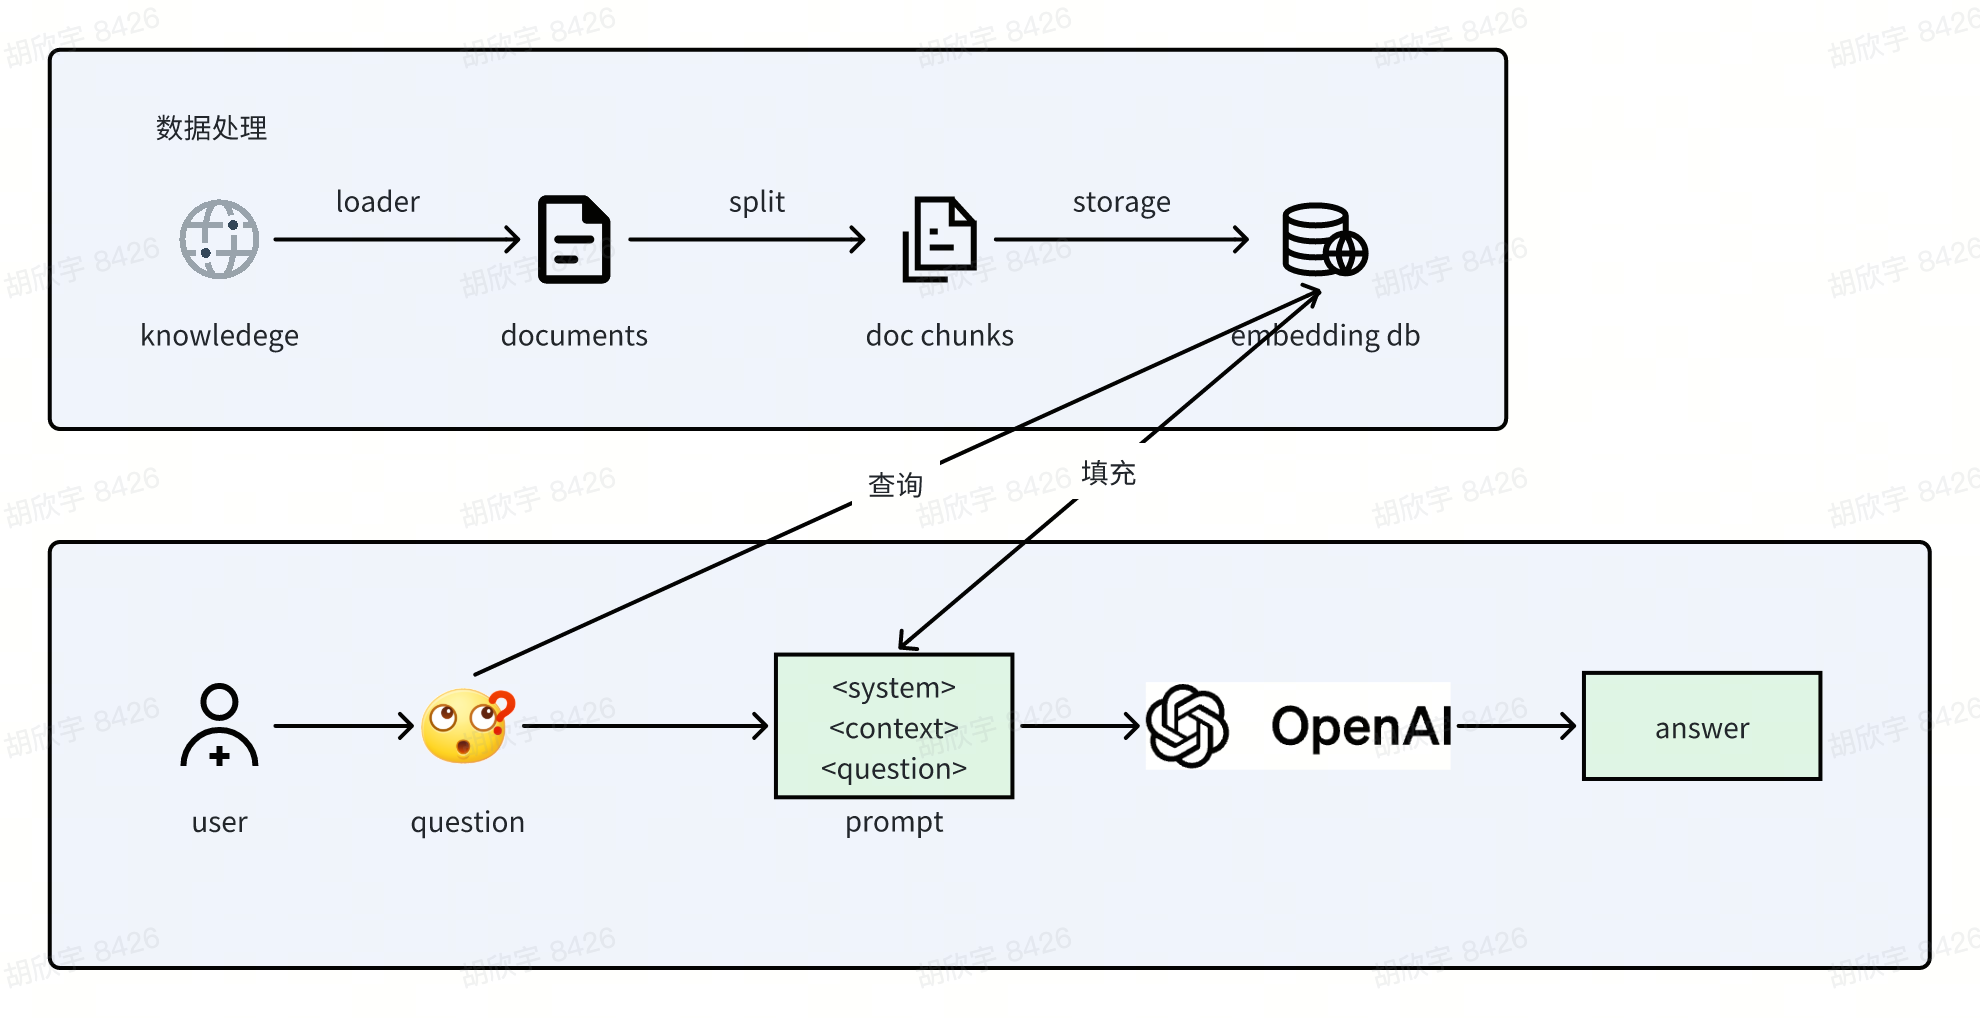


1. **loader** 加载网页内容：使用文档加载器从网页获取信息。
2. **text_splitter** 文本分割：将获取到的文档分割为小块，以便更容易处理。
3. **embedding** 创建向量库：将分割后的文本转换为向量并存储。
4. **retriever** 检索：根据用户输入的问题，从向量库中检索相关内容。
5. **llm** 生成回答：使用生成模型根据检索到的上下文生成答案。


```
embedding = OpenAIEmbeddings(model="text-embedding-v2", check_embedding_ctx_length=False, chunk_size=25)
```
# 文本块的概念
在 LangChain 的OpenAIEmbeddings类里，chunk_size参数所起的作用是控制向 OpenAI API 发送请求时，单次处理的文本块数量。

当你要对较长的文本进行向量化处理时，就需要先把它分割成更小的片段，这些片段就被称作 "文本块"。比如：


```
text = "这是一段很长的文本，我们需要将它...（此处省略若干字）...以便进行向量化处理。"
# 会被分割成：
chunks = ["这是一段很长的文本，", "我们需要将它...", "...以便进行向量化处理。"]
```

# chunk_size 的功能
chunk_size=25意味着每次会把 25 个文本块组合在一起，然后作为一批数据发送给 API





# 1. 向量化的基本概念
向量化（Embedding）是将文本转换为多维向量的过程，使得语义相似的文本在向量空间中距离相近。例如：

"玉渊潭公园的绿地面积是多少？" 和 "玉渊潭的绿化面积" 在向量空间中会很接近。
模型通过计算向量间的余弦相似度来判断文本的相似性。
# 2. OpenAIEmbeddings 参数解析


``` python
embedding = OpenAIEmbeddings(
    model="text-embedding-v2",         # 使用OpenAI的第二代文本嵌入模型
    check_embedding_ctx_length=False,  # 不检查文本长度是否超过模型限制
    chunk_size=25                      # 每次向API发送25个文本块
)
```

## 关键参数说明：
model="text-embedding-v2"
OpenAI 最新的嵌入模型，支持 8191 个 token 的上下文窗口。
输出维度为 1536 维向量，在语义理解任务中表现更好。
check_embedding_ctx_length=False
默认情况下，LangChain 会检查文本长度是否超过模型限制（8191 tokens）。
设置为False后，不进行检查，可能导致长文本被截断（需通过text_splitter提前控制）。
chunk_size=25
控制批量处理的文本块数量。
每次向 OpenAI API 发送 25 个文本块，减少请求次数，提高效率。

In [4]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from google.colab import userdata
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

import os

os.environ["OPENAI_API_BASE"] = userdata.get('OPENAI_API_BASE')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

def queryFromRag(question):
    # 1. 加载文档，抓取网页内容
    loader = WebBaseLoader(
        web_path="https://baike.baidu.com/item/%E6%B5%B7%E6%B7%80%E5%8C%BA?fromtitle=%E6%B5%B7%E6%B7%80&fromid=5104876&fromModule=lemma_search-box",
    )
    docs = loader.load()

    # 2. 文本分块：将长文档分成较小的片段
    # chunk_size=1000 每个文本块的最大字符数（注意：不是token数），将文本拆分成不超过1000字符的小块
    # chunk_overlap=200 相邻文本块之间的重叠字符数，避免关键信息在被分割是在两个chunks中导致上下文丢失
    # # 块1：[字符0-1000]
      # 块2：[字符800-1800]   ← 与块1重叠200字符（800-1000）
      # 块3：[字符1600-2600]  ← 与块2重叠200字符（1600-1800）
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)

    # 3. 向量化：使用OpenAI的文本嵌入模型将文本转换为向量表示
    embedding = OpenAIEmbeddings(model="text-embedding-v2", check_embedding_ctx_length=False, chunk_size=25)
    db = Chroma.from_documents(documents=splits, embedding=embedding)

    # 4. 检索相关内容：根据问题查找最相关的两个文本块
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 2})
    search = retriever.invoke(input=question)
    search_str = " ".join([doc.page_content for doc in search])

    # 5. 生成回答：使用大语言模型生成最终答案
    llm = ChatOpenAI(model="qwen2.5-72b-instruct", temperature=0)
    res = llm.invoke([
        SystemMessage("你是一个智能助手，请根据上下文回答问题，上下文是:\n" + search_str),
        HumanMessage(question)
    ])

    return res.content


result = queryFromRag("玉渊潭公园，是几A景区，绿地面积是多少")
print(result)


玉渊潭公园是国家AAAA旅游景区，建成绿地面积74.44公顷。


In [5]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from google.colab import userdata
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

import os

os.environ["OPENAI_API_BASE"] = userdata.get('OPENAI_API_BASE')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

def queryFromRag(question):
    # 1. 加载文档，抓取网页内容
    loader = WebBaseLoader(
        web_path="https://baike.baidu.com/item/%E6%B5%B7%E6%B7%80%E5%8C%BA?fromtitle=%E6%B5%B7%E6%B7%80&fromid=5104876&fromModule=lemma_search-box",
    )
    docs = loader.load()

    # 2. 文本分块
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)

    # 3. 向量化
    embedding = OpenAIEmbeddings(model="text-embedding-v2", check_embedding_ctx_length=False, chunk_size=25)
    db = Chroma.from_documents(documents=splits, embedding=embedding)

    # 4. 检索相关内容
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 2})
    search = retriever.invoke(input=question)
    search_str = " ".join([doc.page_content for doc in search])

    # 打印检索到的内容
    print("检索到的内容 (search_str):")
    print("=" * 50)
    print(search_str)
    print("=" * 50)

    # 5. 生成回答
    llm = ChatOpenAI(model="qwen2.5-72b-instruct", temperature=0)
    res = llm.invoke([
        SystemMessage("你是一个智能助手，请根据上下文回答问题，上下文是:\n" + search_str),
        HumanMessage(question)
    ])

    return res.content


result = queryFromRag("玉渊潭公园，是几A景区，绿地面积是多少")
print("\n最终回答:")
print(result)

检索到的内容 (search_str):
[147]香山公园拥有碧云寺、宗镜大昭之庙、见心斋、双清别墅、中共中央北京香山革命纪念地旧址等众多文物古迹和红色遗迹。香山红叶驰名中外，主要有8个科涉及14个树种，总株数达14万株，种植面积约1400亩，香山公园有黄栌十万余株，占地1200亩是香山公园红叶的主体树种。1986年就被评为“新北京十六景”之一，成为京城最浓的秋色。 [147]2001年，香山公园被国家旅游局评为AAAA景区。 [147]百望山森林公园百望山森林公园百望山森林公园位于海淀区西北旺镇黑山扈北口19号，占地244.6公顷，主峰海拔210米，京密引水渠绕山而过。植被覆盖率高达95%以上。素有“临东海，拥京华，太行第一哨”之美称。园内建有“首都绿色文化碑林”、佘太君庙、黑山扈战斗纪念园、曲径烟深木栈道等，先后被评为北京市科普教育基地，首都生态文明宣传教育基地，爱国主题教育基地、国家AAA级旅游景区。 [149]海淀公园海淀公园海淀公园位于海淀区新建宫门路2号。始建于2003年4月，公园占地面积约34公顷, 其中园林绿化23公顷, 水面2.8公顷。地跨畅春园、西花园等皇家园林遗址，在风格上秉承了畅春园的自然雅淡。园内选种了雪松、油松、洋槐、银杏、白蜡、碧桃、金银木等85种苗木共60余万株的景观植物。建有淀园花谷、丹棱晴波、万泉漱玉、古亭观稼、仙人承露、讨源书声、御稻流香、双桥诗韵等景区，并设有露天剧场、儿童乐园和足球网球运动场等服务场所。 [151]玉渊潭公园玉渊潭公园玉渊潭公园位于海淀区西三环中路10号，是北京市属十一大公园之一，国家AAAA旅游景区。辽金时称钓鱼台，元朝又名玉渊潭，清朝乾隆皇帝在此修建行宫。公园规划总面积136.69公顷，其中水域面积61公顷，建成绿地面积74.44公顷，绿化覆盖率达到95%以上，园内现有各种植物约19.95万株。 [153]有樱花园、湿地园、万柳堂、中国少年英雄纪念碑、玉渊春秋等一批特色景区和园林建筑。其中是国内最大的樱花专类园之一。占地25公顷，栽有2000余株樱花，并形成了京城著名的“樱花八景”。 [147]香山公园拥有碧云寺、宗镜大昭之庙、见心斋、双清别墅、中共中央北京香山革命纪念地旧址等众多文物古迹和红色遗迹。香山红叶驰名中外，主要有8个科涉及14个树种，总株数达14万株，种植面积约1400亩，香山公园有黄栌十万